<h1><center> Netflix Recommendation System </center></h1>

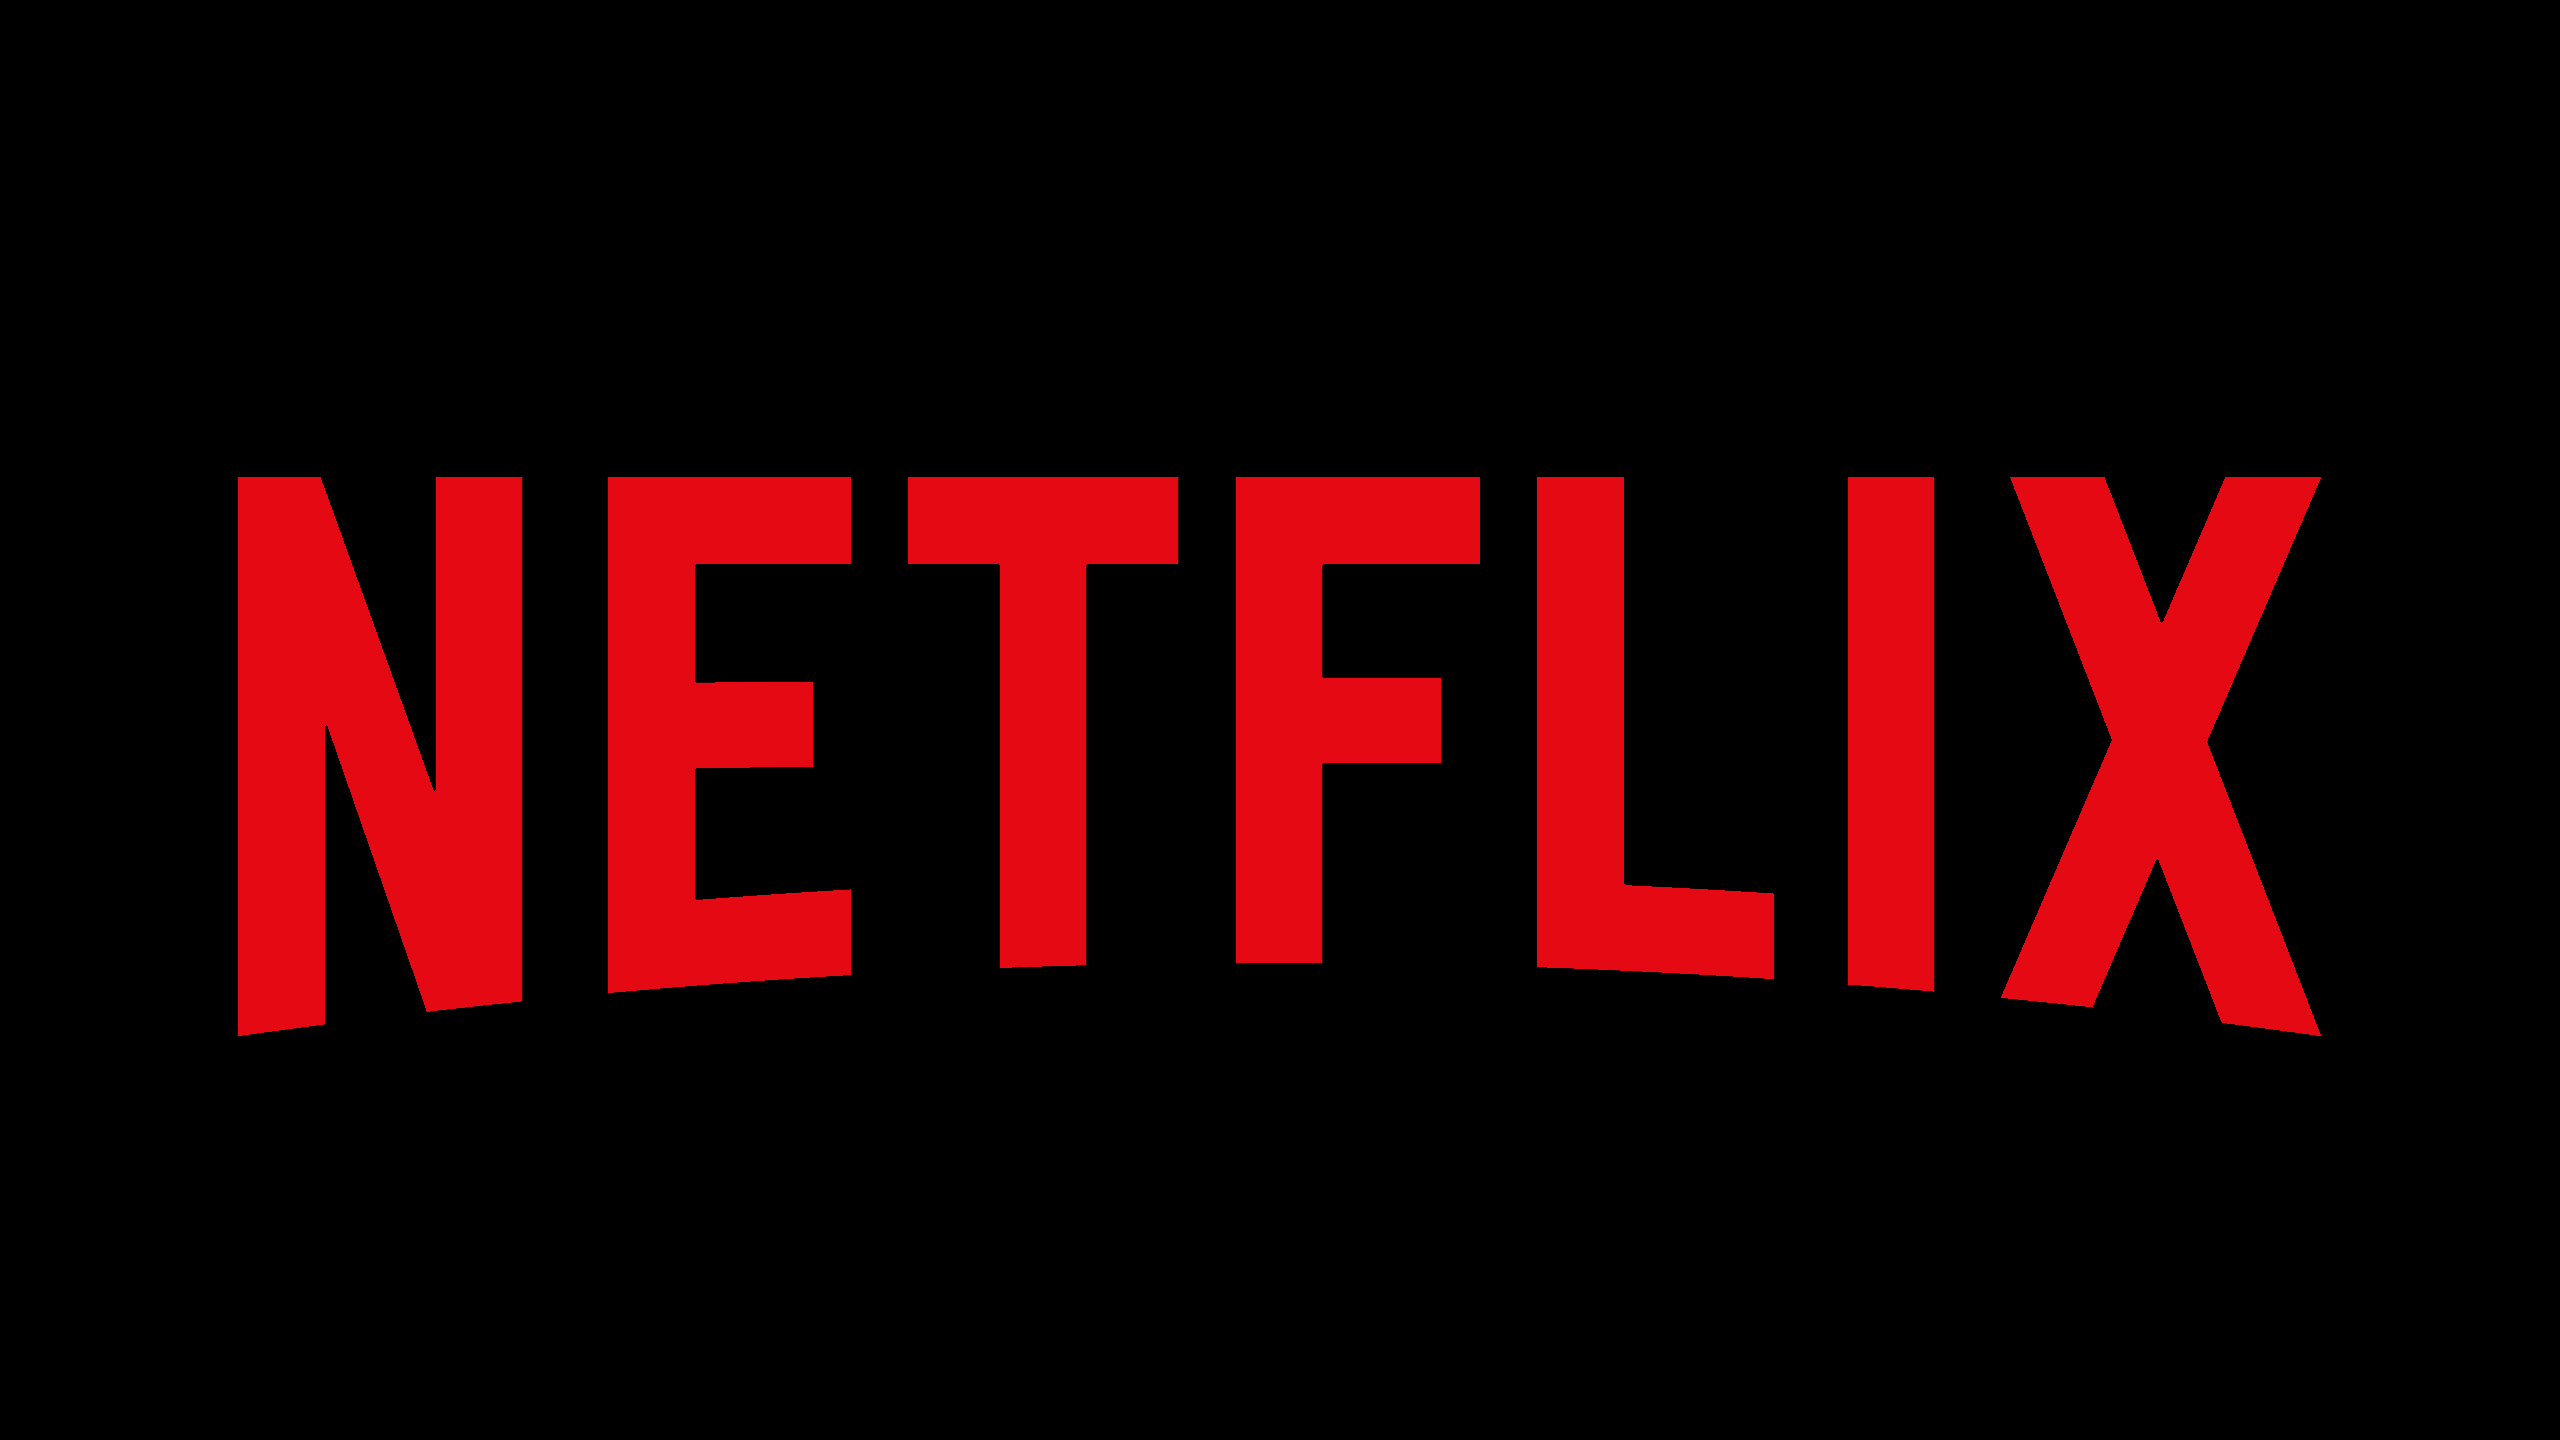

Netflix is an American over-the-top content platform and production company. Netflix was founded in 1997 and ever since has been bringing to us amazing content be it movies or series. Netflix has proven to be a total stress buster to many of us, especially considering the current pandemic around the world. They provide a vast range of content in various languages, genres, and time. May it be classics or modern pictures think about it and you may find it on Netflix.

This notebook aims at creating a movie assistant such that you can find several suggestions of must-watch based on the movies of your choice. For this, we will use the concept called "Recommender systems".

**Recommender systems** are an important class of machine learning that offer suggestions to users based on a degree of relevance. It can be categorized as collaborative filtering or a content-based system. We will create both these models for demonstration.

Kindly provide an upvote if this notebook was useful. Also, I would greatly appreciate any feedback or suggestions for improvement. 

Thank-you :)


# Data Cleaning and Processing

In [1]:
import datetime
import unidecode
import numpy as np
import pandas as pd
from numpy import dot
import seaborn as sns
from numpy import random
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors   

In [2]:
Netflix = pd.read_csv("netflix_titles.csv")
print("Dataframe Details")
print("Total Rows: {}\nTotal Columns: {}".format(Netflix.shape[0],Netflix.shape[1]))

Netflix.dropna(subset=['director','cast','country','date_added','rating'],axis=0,inplace=True)
Netflix.drop(['show_id','description'],axis=1,inplace=True)
print()
print("Details after dropping null rows and columns")
print("Total Rows: {}\nTotal Columns: {}".format(Netflix.shape[0],Netflix.shape[1]))

NetflixDatabase = Netflix.copy()

print()
print("Database Created")

Dataframe Details
Total Rows: 7787
Total Columns: 12

Details after dropping null rows and columns
Total Rows: 4808
Total Columns: 10

Database Created


In [3]:
Netflix['cast'] = Netflix['cast'].apply(lambda x : unidecode.unidecode(x))

Netflix['date_added'] = Netflix['date_added'].apply(lambda x : x[-4:])
Netflix['date_added'] = Netflix['date_added'].astype('int64')
Netflix['show_age'] = 2021 - Netflix['date_added']
Netflix['show_age'] = Netflix['show_age'].apply(lambda x : str(x)+" years")

NetflixVis = Netflix.copy()

Netflix.drop(['date_added','release_year'],axis=1,inplace=True)

print("Data Procesing Done")

Data Procesing Done


# Data Visualization

In [4]:
NetflixVis.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,show_age
1,Movie,7:19,Jorge Michel Grau,"Demian Bichir, Hector Bonilla, Oscar Serrano, ...",Mexico,2016,2016,TV-MA,93 min,"Dramas, International Movies",5 years
2,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018,2011,R,78 min,"Horror Movies, International Movies",3 years
3,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...",4 years
4,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020,2008,PG-13,123 min,Dramas,1 years
5,TV Show,46,Serdar Akar,"Erdal Besikcioglu, Yasemin Allen, Melis Birkan...",Turkey,2017,2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",4 years


Text(0, 0.5, 'Count Of Content')

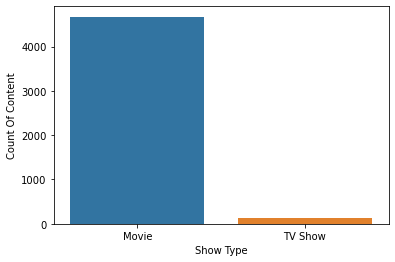

In [5]:
sns.countplot(x = 'type', data = NetflixVis)

plt.xlabel("Show Type")
plt.ylabel("Count Of Content")

A majority of the added content on netflix seem to be movies

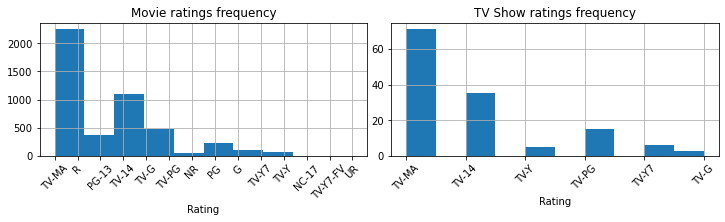

In [6]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
movies_rating = NetflixVis[NetflixVis['type'] == "Movie"]
movies_rating.rating.hist(bins=10)
plt.xlabel("Rating")
plt.title("Movie ratings frequency")
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
show_rating = NetflixVis[NetflixVis['type'] == "TV Show"]
show_rating.rating.hist(bins=10)
plt.xlabel("Rating")
plt.title("TV Show ratings frequency")
plt.xticks(rotation = 45)

plt.tight_layout(pad=0.4)

Netflix targets older/mature audience as there are several contents whether movies or tv shows rated as "TV Mature Audience (TV-MA)"

Text(0.5, 0, 'Show Type')

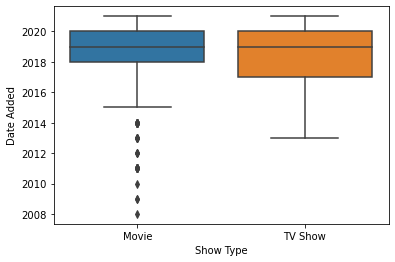

In [7]:
sns.boxplot(x = 'type',y = 'date_added',data=NetflixVis)

plt.ylabel("Date Added")
plt.xlabel("Show Type")

A few movies have been added between 2008 - 2015. Many movies and TV Shows were added after 2015 and 2013 respectively.

<AxesSubplot:title={'center':'Number of movies over the years'}>

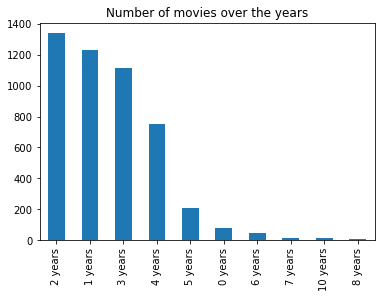

In [8]:
age = NetflixVis['show_age'].value_counts()[:10]
age.plot(kind='bar',title='Number of movies over the years')

Major content on Netflix is about 2 years old. Thus, pointing at several add ons in the year 2018-2019. 

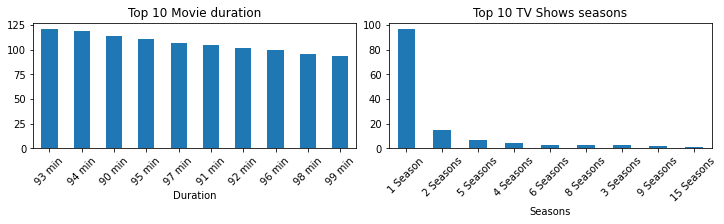

In [9]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
movies_duration = NetflixVis[NetflixVis['type'] == "Movie"]
movies_duration = movies_duration['duration'].value_counts()[:10]
movies_duration.plot(kind='bar',title='Number of movies over the years')
plt.xlabel("Duration")
plt.title("Top 10 Movie duration")
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
show_duration = NetflixVis[NetflixVis['type'] == "TV Show"]
show_duration = show_duration['duration'].value_counts()[:10]
show_duration.plot(kind='bar',title='Number of movies over the years')
plt.xlabel("Seasons")
plt.title("Top 10 TV Shows seasons")
plt.xticks(rotation = 45)

plt.tight_layout(pad=0.3)

The length of each movie is mostly above 1 and a half hour, whereas several TV Shows seems to be limited series of 1 season.  

<AxesSubplot:title={'center':'Number of movies over the years'}>

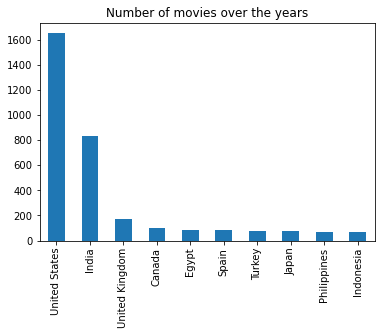

In [10]:
country = NetflixVis['country'].value_counts()[:10]
country.plot(kind='bar',title='Number of movies over the years')

The United States of America is the leading content contributor followed by India.

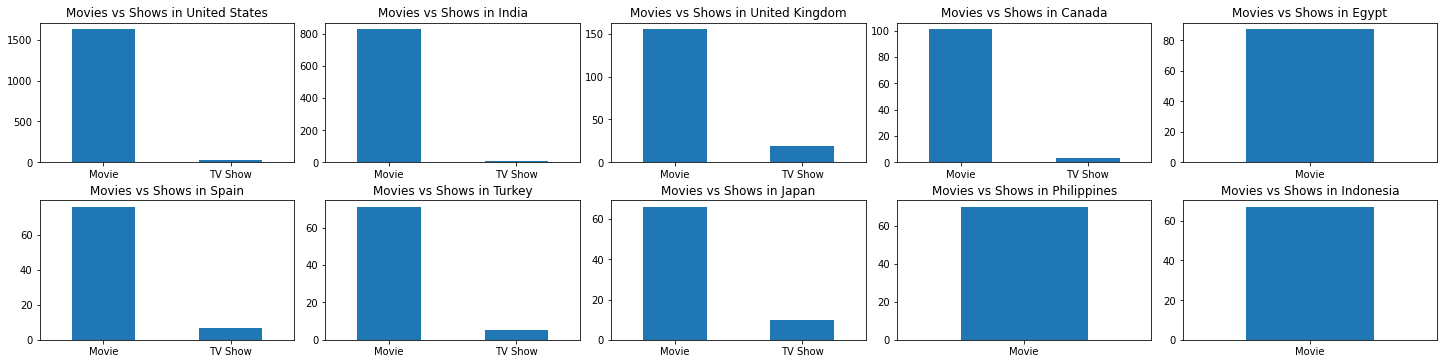

In [11]:
plt.figure(figsize=(20,5))

for i in range(len(country.index)):
    plt.subplot(2,5,i+1)
    moviesvsshows = NetflixVis[NetflixVis['country'] == country.index[i]]
    moviesvsshows = moviesvsshows['type'].value_counts()
    moviesvsshows.plot(kind='bar')
    plt.title("Movies vs Shows in {}".format(country.index[i]))
    plt.xticks(rotation = 360)
    
plt.tight_layout(pad=0.5)

Diving deeper into contributions we see that Egypt, The Philippines, and Indonesia are majorly contributing several movies. Although The United States of America and India are the biggest content contributor, we observe United Kingdom, Spain, Japan, Turkey, and Canada offer more TV Shows. 

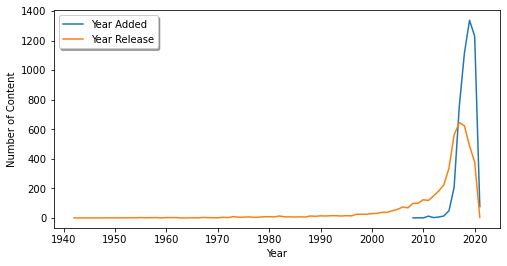

In [12]:
added_year = pd.pivot_table(NetflixVis, values='title', index='date_added', aggfunc=np.count_nonzero)
release_year = pd.pivot_table(NetflixVis, values='title', index='release_year', aggfunc=np.count_nonzero)

plt.figure(figsize=(8,4))
sns.lineplot(x='date_added', y='title', data=added_year, label='Year Added')
sns.lineplot(x='release_year', y='title', data=release_year, label='Year Release')
plt.xlabel("Year")
plt.ylabel("Number of Content")

plt.legend(shadow=True)

Movies as old as 50 years have found their way into OTT platforms

<AxesSubplot:title={'center':'Genre of movies over the years'}>

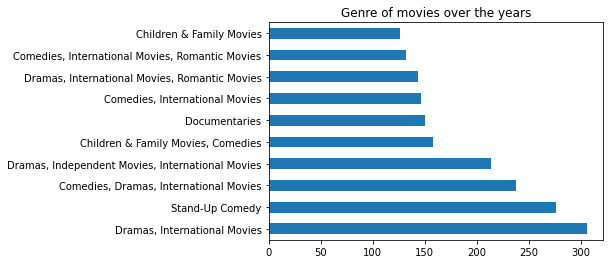

In [13]:
genre = NetflixVis["listed_in"].value_counts()[:10]
genre.plot(kind='barh',title='Genre of movies over the years')

Netflix offer a number of Stand-ups, Dramas and International Movies  

Text(0, 0.5, 'Countries and Genre')

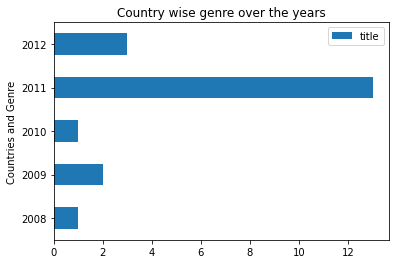

In [14]:
countrygenre = pd.pivot_table(NetflixVis, values='title', index=['country','listed_in'],aggfunc=np.count_nonzero).sort_values(by=['title']
                                                                                                    ,ascending=False)
countrygenre = added_year[:5]   
countrygenre.plot(kind='barh',title='Country wise genre over the years')

plt.ylabel("Countries and Genre")

The United States of America has maximum content catering to Stand-Up Comedy whereas India has a maximum genre of Drama.

# Summary of Analysis

<h4><u>Analysis based on given data</u></h4>

* Netflix offers a variety of movies ranging from different languages to a vast genre.
* In many countries OTT platforms don’t come under government censorship, thus Netflix one of such OTT platforms offers majority content catering to their "The Mature Audience".
* Initially, TV Shows had not seen the majestic light of the OTT Platform, it was first available for online streaming in the year 2013.
* Netflix offered few movies between the years 2008 - 2015, before adding a vast range thereafter.
* Several TV Shows had been added between 2017 - 2019, probably to cater to the increasing demand and fascination revolving around TV Shows.
* In the last 2 years, there were several contents added.
* Among the leading 10 countries that contributed content to Netflix The United States of America and India topped the list.
* United Kingdom, Spain, Japan, Turkey, and Canada offer more TV Shows than any other leading contributors.
* Movies and TV Shows have a maximum length of 1 and a half hours and 1 season respectively.
* Netflix has added several fine evergreen classics.
* The majority of content on Netflix is Stand-Ups, Dramas, and International Movies
* The United States of America and India have contributed several contents of Stand-ups and Drama's respectively.


# Recommendation System

## 1. Content Based Recommendation System

In [15]:
Begin = datetime.datetime.now()

single = ['type','rating', 'show_age','duration']
lists = ['country','cast','director', 'listed_in']

for j in lists:
    Netflix[j] = Netflix[j].apply(lambda x : x.replace(" ","").split(","))

NetflixEncoded = pd.DataFrame({'Index':Netflix.index})
NetflixEncoded = NetflixEncoded.set_index('Index')
print("Encoder Dataframe Created")

Encoder Dataframe Created


In [16]:
# CODED FOR SINGLE ENTRIES

for i in single:
    for j in Netflix[i].unique():
        NetflixEncoded[j] = 0
           
for i in range(len(Netflix)):
    row = Netflix.index[i] 
    for j in single:    
        value = Netflix[j][row]        
        NetflixEncoded.loc[row,value] = 1     

In [17]:
# CODED FOR MULTIPLE ENTRIES
    
for i in lists:
    holder = []
    
    for j in range(len(Netflix[i])):
        row = Netflix.index[j] 
        holder.append([x.strip() for x in Netflix[i][row]])

    finalcol = [l for m in holder for l in m]
    finalcol = list(set(finalcol))
    
    for cols in finalcol:
        NetflixEncoded[cols] = 0
     
for i in range(len(Netflix)):
    row = Netflix.index[i] 
    for j in lists:
        for value in Netflix[j][row]: 
            NetflixEncoded.loc[row,value] = 1  
             
NetflixEncoded.fillna(0,inplace=True)  
print("Encoding Dataframe Done")  

Encoding Dataframe Done


In [18]:
NetflixDatabase.reset_index(inplace=True) 
NetflixDatabase.drop('index',axis=1,inplace=True)

NetflixEncoded.reset_index(inplace=True) 
NetflixEncoded.drop('Index',axis=1,inplace=True)

print("Index Reset for 'NetflixDatabase' and 'NetflixEncoded'")  

Index Reset for 'NetflixDatabase' and 'NetflixEncoded'


In [19]:
def content_recommendation_system(title):
    cossim_values = []
    
    try:
        row = NetflixDatabase[NetflixDatabase['title'] == title].index[0]
        row = NetflixEncoded.index[row]

        A = np.array(NetflixEncoded.iloc[row])

        for j in range(len(NetflixEncoded)):
            B = np.array(NetflixEncoded.iloc[j])
            cossim = dot(A,B)/(norm(A)*norm(B))
            cossim_values.append(cossim)

        NetflixDatabase['cosine_similarity'] = cossim_values
        results = NetflixDatabase.sort_values('cosine_similarity', ascending=False) 
        results = results.head(6).iloc[1:,:-1]
        return(results)
    
    except:
        print("Sorry there seems to be a problem. Kindly try another movies or show")       

In [20]:
content_recommendation_system("Mercy")   

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in
1238,Movie,El Camino: A Breaking Bad Movie,Vince Gilligan,Aaron Paul,United States,"October 11, 2019",2019,TV-MA,123 min,"Dramas, Thrillers"
1139,Movie,Dog Eat Dog,Paul Schrader,"Nicolas Cage, Willem Dafoe, Christopher Matthe...",United States,"December 31, 2016",2016,TV-MA,93 min,"Dramas, Thrillers"
672,Movie,Blue Jay,Alex Lehmann,"Sarah Paulson, Mark Duplass, Clu Gulager",United States,"December 6, 2016",2016,TV-MA,81 min,"Dramas, Independent Movies, Romantic Movies"
3987,Movie,The Good Neighbor,Kasra Farahani,"James Caan, Logan Miller, Keir Gilchrist, Laur...",United States,"December 5, 2016",2016,TV-MA,97 min,"Dramas, Independent Movies, Thrillers"
3187,Movie,Rebirth,Karl Mueller,"Fran Kranz, Adam Goldberg, Nicky Whelan, Luis ...",United States,"July 15, 2016",2016,TV-MA,101 min,"Dramas, Thrillers"


In [21]:
content_recommendation_system("Gotham")   

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in
4767,TV Show,You,Lee Toland Krieger,"Penn Badgley, Elizabeth Lail, Shay Mitchell, J...",United States,"December 26, 2019",2019,TV-MA,2 Seasons,"Crime TV Shows, Romantic TV Shows, TV Dramas"
3315,TV Show,Sacred Games,"Vikramaditya Motwane, Anurag Kashyap","Saif Ali Khan, Nawazuddin Siddiqui, Radhika Ap...","India, United States","August 15, 2019",2019,TV-MA,2 Seasons,"Crime TV Shows, International TV Shows, TV Dramas"
1935,TV Show,Jack Taylor,Stuart Orme,"Iain Glen, Killian Scott, Nora-Jane Noone, Tar...","United States, Ireland","March 31, 2013",2016,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas"
2844,TV Show,Nowhere Man,DJ Chen,"Alyssa Chia, Mavis Fan, Joseph Chang, Wang Po-...",Taiwan,"October 31, 2019",2019,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
330,Movie,Amy Schumer Growing,Amy Schumer,Amy Schumer,United States,"March 19, 2019",2019,TV-MA,61 min,Stand-Up Comedy


In [22]:
content_recommendation_system("Age")

Sorry there seems to be a problem. Kindly try another movies or show


In [23]:
End = datetime.datetime.now()
RunTime = round((End - Begin).total_seconds()/60.0)
print("Total Time Taken by 'Content Based Recommendation System' was {} Mins".format(RunTime))  

Total Time Taken by 'Content Based Recommendation System' was 3 Mins


## 2. Collaborative Based Recommendation System

Although there is no room for a collaborative recommendation system with this single dataset, let us play around with the data and explore this model.

In [24]:
Begin = datetime.datetime.now()

userid = np.arange(1, 2000+1, 1)
userid = ["uid" + str(userid) for userid in userid]

usercols = Netflix['title'].unique()
userwatch = random.randint(5, size=(2000,len(usercols)))

watchhist = pd.DataFrame(userwatch,columns=usercols)
watchhist.insert(0,"user_id",userid)
watchhist = watchhist.set_index('user_id')
watchhist = watchhist.transpose()
watchhist.index.name = 'title'

watchhist.head()

user_id,uid1,uid2,uid3,uid4,uid5,uid6,uid7,uid8,uid9,uid10,...,uid1991,uid1992,uid1993,uid1994,uid1995,uid1996,uid1997,uid1998,uid1999,uid2000
title,,,,,,,,,,,,,,,,,,,,,
7:19,3,4,4,2,2,3,1,2,3,3,...,4,2,1,2,4,3,3,4,3,0
23:59,3,3,4,2,1,3,1,4,1,2,...,3,3,4,0,4,0,2,3,4,3
9,0,2,4,0,4,0,1,0,2,0,...,3,0,1,4,3,1,4,2,0,0
21,3,2,0,1,3,0,4,4,3,2,...,0,2,3,1,1,1,3,3,1,2
46,1,2,4,2,2,0,2,0,2,3,...,0,4,0,1,0,3,1,2,1,1


In [25]:
sparselist = csr_matrix(watchhist.values)
watchhist.reset_index(inplace=True)

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn.fit(sparselist)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [26]:
def collab_recommendation_system(title):
    
    try:
        row = watchhist[watchhist['title'] == title].index[0]

        distances , indices = knn.kneighbors(sparselist[row],n_neighbors=5+1) 
        indices = [l for m in indices.tolist() for l in m]
        distances = [l for m in distances.tolist() for l in m]

        recommendation = {}

        for i in range(1,len(indices)):
            movie_name = watchhist.iloc[indices[i]]['title']
            recommendation[movie_name] = distances[i]

        recommendation = {k: v for k, v in sorted(recommendation.items(), key=lambda item: item[1])}
        results = pd.DataFrame()

        for key,value in recommendation.items():
            row = NetflixDatabase[NetflixDatabase['title'] == key]
            results = results.append(row)

        return(results.iloc[1:,:-1])
        
    except:
        print("Sorry there seems to be a problem. Kindly try another movies or show")   

In [27]:
collab_recommendation_system("Mercy")   

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in
2556,Movie,Mike Birbiglia: My Girlfriend's Boyfriend,Seth Barrish,Mike Birbiglia,United States,"May 2, 2020",2013,TV-14,76 min,Stand-Up Comedy
305,Movie,Always Be My Maybe,Dan Villegas,"Gerald Anderson, Arci Muñoz, Cacai Bautista, R...",Philippines,"September 1, 2020",2016,TV-14,112 min,"International Movies, Romantic Movies"
1195,Movie,Dry Martina,Che Sandoval,"Antonella Costa, Patricio Contreras, Geraldine...","Chile, Argentina","May 11, 2019",2018,TV-MA,100 min,"Dramas, Independent Movies, International Movies"
1097,Movie,Dev.D,Anurag Kashyap,"Abhay Deol, Mahie Gill, Kalki Koechlin, Sindba...",India,"October 1, 2018",2009,TV-MA,137 min,"Dramas, International Movies, Romantic Movies"


In [28]:
collab_recommendation_system("Gotham")

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in
80,Movie,4th Republic,Ishaya Bako,"Kate Henshaw-Nuttal, Enyinna Nwigwe, Linda Eji...",Nigeria,"June 13, 2020",2019,TV-MA,120 min,"Dramas, International Movies, Thrillers"
2888,Movie,Once in a Lifetime Sessions with Kasabian,Matt Askem,"Sergio Pizzorno, Tom Meighan, Chris Edwards, I...",United States,"December 15, 2018",2018,TV-MA,79 min,"Documentaries, Music & Musicals"
3514,Movie,Singham,Rohit Shetty,"Ajay Devgn, Kajal Aggarwal, Prakash Raj, Sonal...",India,"November 19, 2020",2011,TV-14,142 min,"Action & Adventure, Dramas, International Movies"
1389,Movie,Flock of Four,Gregory Caruso,"Braeden Lemasters, Isaac Jay, Uriah Shelton, D...",United States,"August 1, 2018",2018,TV-MA,83 min,"Dramas, Independent Movies, Music & Musicals"


In [29]:
collab_recommendation_system("Age")

Sorry there seems to be a problem. Kindly try another movies or show


In [30]:
End = datetime.datetime.now()
RunTime = round((End - Begin).total_seconds()/60.0)
print("Total Time Taken by 'Collaborative Based Recommendation System' was {} Mins".format(RunTime))  

Total Time Taken by 'Collaborative Based Recommendation System' was 0 Mins


# Reference

Content-Based Recommendation System:<br>
Thank you for this amazing concept. Do check out this piece<br>
https://www.kaggle.com/eward96/netflix-recommendation-engine